In [ ]:

from google.colab import files
files.upload()


Saving kaggle (3).json to kaggle (3).json


{'kaggle (3).json': b'{"username":"taiseerbadralaidroos","key":"700d9b28a66e511d71acba926896759d"}'}

In [ ]:

import os
# إنشاء مجلد .kaggle إذا لم يكن موجود
os.makedirs("/root/.kaggle", exist_ok=True)

# نقل الملف المرفوع إلى مجلد .kaggle باسم kaggle.json
!mv "kaggle (3).json" /root/.kaggle/kaggle.json

# إعطاء الصلاحيات للملف
!chmod 600 /root/.kaggle/kaggle.json

# تحميل مجموعة البيانات
!kaggle datasets download -d foyez767/x-ray-images-of-fractured-and-healthy-bones

# فك الضغط عن الملفات
!unzip x-ray-images-of-fractured-and-healthy-bones.zip -d ./xray_data


Streaming output truncated to the last 5000 lines.
  inflating: ./xray_data/X-ray Imaging Dataset for Detecting Fractured vs. Non-Fractured Bones/Augmented Dataset/Non-Fractured/Non-Fractured (1062).jpg  
  inflating: ./xray_data/X-ray Imaging Dataset for Detecting Fractured vs. Non-Fractured Bones/Augmented Dataset/Non-Fractured/Non-Fractured (1063).jpg  
  inflating: ./xray_data/X-ray Imaging Dataset for Detecting Fractured vs. Non-Fractured Bones/Augmented Dataset/Non-Fractured/Non-Fractured (1064).jpg  
  inflating: ./xray_data/X-ray Imaging Dataset for Detecting Fractured vs. Non-Fractured Bones/Augmented Dataset/Non-Fractured/Non-Fractured (1065).jpg  
  inflating: ./xray_data/X-ray Imaging Dataset for Detecting Fractured vs. Non-Fractured Bones/Augmented Dataset/Non-Fractured/Non-Fractured (1066).jpg  
  inflating: ./xray_data/X-ray Imaging Dataset for Detecting Fractured vs. Non-Fractured Bones/Augmented Dataset/Non-Fractured/Non-Fractured (1067).jpg  
  inflating: ./xray_data/

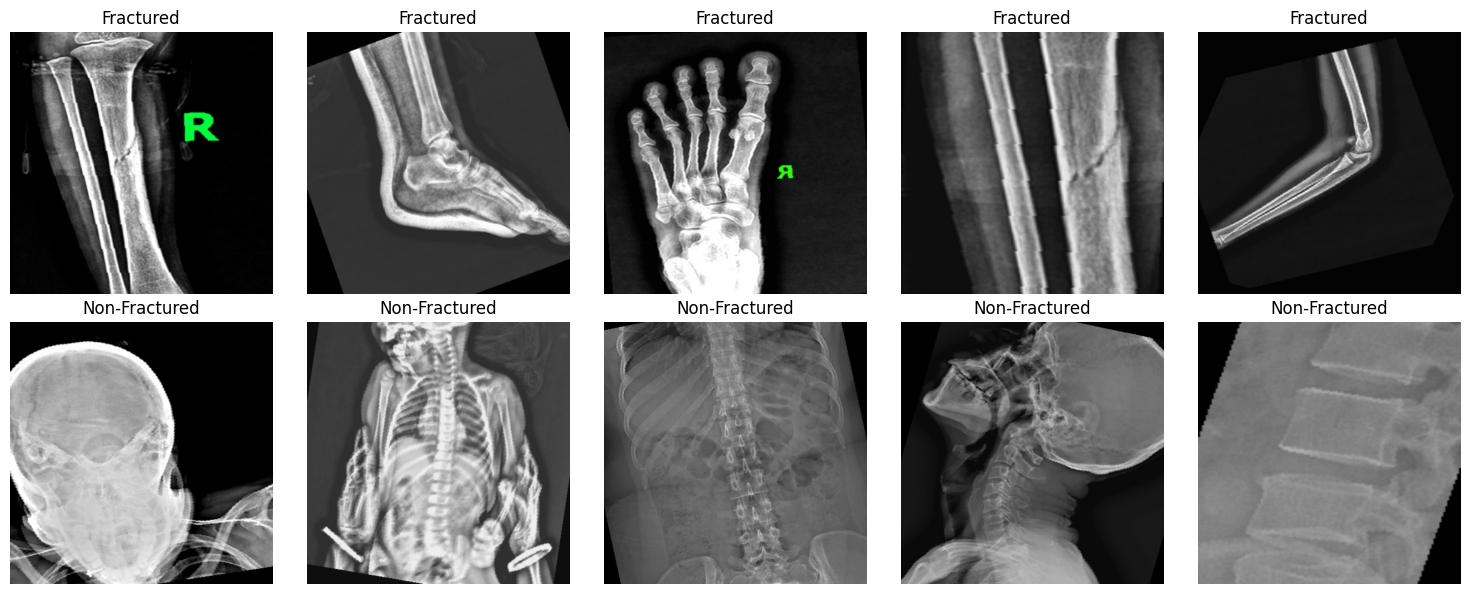

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

# مسار البيانات
base_dir = "./xray_data/X-ray Imaging Dataset for Detecting Fractured vs. Non-Fractured Bones/Augmented Dataset"

# الفئات
classes = ["Fractured", "Non-Fractured"]

# عرض 5 صور عشوائية لكل فئة
plt.figure(figsize=(15, 6))
for idx, cls in enumerate(classes):
    cls_path = os.path.join(base_dir, cls)
    images = os.listdir(cls_path)
    sample_images = random.sample(images, 5)
    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(cls_path, img_file)
        img = mpimg.imread(img_path)
        plt.subplot(len(classes), 5, idx*5 + i + 1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(cls)
plt.tight_layout()
plt.show()


In [ ]:
!pip install -q tensorflow

import os
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# ========================
# 1) إعداد المسار والبارامترات
# ========================
base_dir = "./xray_data/X-ray Imaging Dataset for Detecting Fractured vs. Non-Fractured Bones/Augmented Dataset"
img_size = (300, 300)  # حجم أكبر لـEfficientNetB3
batch_size = 16
seed = 42

# ========================
# 2) Generators + Augmentation
# ========================
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    seed=seed
)
validation_generator = valid_datagen.flow_from_directory(
    base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    seed=seed
)

# ========================
# 3) class weights
# ========================
counter = Counter(train_generator.classes)
print("توزيع الفئات في التدريب:", counter)
total = float(sum(counter.values()))
class_weight = {cls: total/count for cls, count in counter.items()}
print("class_weight:", class_weight)

# ========================
# 4) بناء النموذج
# ========================
base_model = EfficientNetB3(weights='imagenet', include_top=False,
                            input_shape=(img_size[0], img_size[1], 3))

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# تجميد القاعدة أولًا
for layer in base_model.layers:
    layer.trainable = False

# compile أولي
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy', metrics=['accuracy'])

# ========================
# 5) Callbacks
# ========================

checkpoint = ModelCheckpoint('fracture_model_epoch_{epoch:02d}.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=False,  # مهم: سيحفظ كل إيبوك
                             mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3,
                              verbose=1, min_lr=1e-7)
early_stop = EarlyStopping(monitor='val_loss', patience=7,
                           restore_best_weights=True, verbose=1)

# ========================
# 6) تدريب رأس الشبكة
# ========================
initial_epochs = 5
history1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=initial_epochs,
    class_weight=class_weight,
    callbacks=[checkpoint, reduce_lr],
    verbose=1
)

# ========================
# 7) Fine-tuning: فك آخر 100 طبقة + SGD
# ========================
num_unfreeze = 100
for layer in base_model.layers[-num_unfreeze:]:
    layer.trainable = True

model.compile(optimizer=SGD(learning_rate=1e-5, momentum=0.9, nesterov=True),
              loss='binary_crossentropy', metrics=['accuracy'])

fine_tune_epochs = 15
total_epochs = initial_epochs + fine_tune_epochs

history2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    initial_epoch=initial_epochs,
    epochs=total_epochs,
    class_weight=class_weight,
    callbacks=[checkpoint, reduce_lr, early_stop],
    verbose=1
)

print("التدريب انتهى. النموذج الأفضل محفوظ في 'best_fracture_model.h5'")
# model.load_weights('best_fracture_model.h5')  # يمكنك تحميله هنا إذا أردت


Found 7440 images belonging to 2 classes.
Found 1860 images belonging to 2 classes.
توزيع الفئات في التدريب: Counter({np.int32(0): 3720, np.int32(1): 3720})
class_weight: {np.int32(0): 2.0, np.int32(1): 2.0}
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.7570 - loss: 1.0629
Epoch 1: saving model to fracture_model_epoch_01.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 235s 409ms/step - accuracy: 0.7571 - loss: 1.0625 - val_accuracy: 0.9237 - val_loss: 0.2001 - learning_rate: 1.0000e-04
Epoch 2/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8675 - loss: 0.6089
Epoch 2: saving model to fracture_model_epoch_02.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 209s 356ms/step - accuracy: 0.8675 - loss: 0.6089 - val_accuracy: 0.9548 - val_loss: 0.1365 - learning_rate: 1.0000e-04
Epoch 3/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8903 - loss: 0.5149
Epoch 3: saving model to fracture_model_epoch_03.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 169s 363ms/step - accuracy: 0.8903 - loss: 0.5148 - val_accuracy: 0.9591 - val_loss: 0.1186 - learning_rate: 1.0000e-04
Epoch 4/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9033 - loss: 0.4813
Epoch 4: saving model to fracture_model_epoch_04.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 165s 354ms/step - accuracy: 0.9033 - loss: 0.4812 - val_accuracy: 0.9796 - val_loss: 0.0822 - learning_rate: 1.0000e-04
Epoch 5/5
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.9192 - loss: 0.3934
Epoch 5: saving model to fracture_model_epoch_05.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 166s 357ms/step - accuracy: 0.9192 - loss: 0.3934 - val_accuracy: 0.9785 - val_loss: 0.0769 - learning_rate: 1.0000e-04
Epoch 6/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8553 - loss: 0.6859
Epoch 6: saving model to fracture_model_epoch_06.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 235s 401ms/step - accuracy: 0.8553 - loss: 0.6859 - val_accuracy: 0.9484 - val_loss: 0.1508 - learning_rate: 1.0000e-05
Epoch 7/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8619 - loss: 0.6311
Epoch 7: saving model to fracture_model_epoch_07.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 169s 362ms/step - accuracy: 0.8619 - loss: 0.6311 - val_accuracy: 0.9543 - val_loss: 0.1381 - learning_rate: 1.0000e-05
Epoch 8/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8724 - loss: 0.5810
Epoch 8: saving model to fracture_model_epoch_08.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 168s 362ms/step - accuracy: 0.8724 - loss: 0.5811 - val_accuracy: 0.9602 - val_loss: 0.1272 - learning_rate: 1.0000e-05
Epoch 9/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8770 - loss: 0.5914
Epoch 9: saving model to fracture_model_epoch_09.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 169s 364ms/step - accuracy: 0.8770 - loss: 0.5914 - val_accuracy: 0.9645 - val_loss: 0.1202 - learning_rate: 1.0000e-05
Epoch 10/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8762 - loss: 0.5782
Epoch 10: saving model to fracture_model_epoch_10.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 170s 365ms/step - accuracy: 0.8762 - loss: 0.5781 - val_accuracy: 0.9667 - val_loss: 0.1102 - learning_rate: 1.0000e-05
Epoch 11/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8813 - loss: 0.5665
Epoch 11: saving model to fracture_model_epoch_11.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 169s 363ms/step - accuracy: 0.8813 - loss: 0.5665 - val_accuracy: 0.9667 - val_loss: 0.1075 - learning_rate: 1.0000e-05
Epoch 12/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8909 - loss: 0.5139
Epoch 12: saving model to fracture_model_epoch_12.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 168s 362ms/step - accuracy: 0.8909 - loss: 0.5139 - val_accuracy: 0.9694 - val_loss: 0.1011 - learning_rate: 1.0000e-05
Epoch 13/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8911 - loss: 0.5126
Epoch 13: saving model to fracture_model_epoch_13.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 169s 363ms/step - accuracy: 0.8911 - loss: 0.5126 - val_accuracy: 0.9715 - val_loss: 0.0981 - learning_rate: 1.0000e-05
Epoch 14/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9019 - loss: 0.4872
Epoch 14: saving model to fracture_model_epoch_14.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 169s 364ms/step - accuracy: 0.9019 - loss: 0.4872 - val_accuracy: 0.9742 - val_loss: 0.0922 - learning_rate: 1.0000e-05
Epoch 15/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8961 - loss: 0.5129
Epoch 15: saving model to fracture_model_epoch_15.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 171s 368ms/step - accuracy: 0.8961 - loss: 0.5129 - val_accuracy: 0.9747 - val_loss: 0.0869 - learning_rate: 1.0000e-05
Epoch 16/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9058 - loss: 0.4720
Epoch 16: saving model to fracture_model_epoch_16.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 167s 360ms/step - accuracy: 0.9058 - loss: 0.4719 - val_accuracy: 0.9737 - val_loss: 0.0864 - learning_rate: 1.0000e-05
Epoch 17/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9086 - loss: 0.4518
Epoch 17: saving model to fracture_model_epoch_17.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 171s 368ms/step - accuracy: 0.9086 - loss: 0.4518 - val_accuracy: 0.9774 - val_loss: 0.0817 - learning_rate: 1.0000e-05
Epoch 18/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.9057 - loss: 0.4561
Epoch 18: saving model to fracture_model_epoch_18.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 168s 361ms/step - accuracy: 0.9057 - loss: 0.4561 - val_accuracy: 0.9763 - val_loss: 0.0803 - learning_rate: 1.0000e-05
Epoch 19/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9155 - loss: 0.4222
Epoch 19: saving model to fracture_model_epoch_19.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 171s 368ms/step - accuracy: 0.9155 - loss: 0.4223 - val_accuracy: 0.9801 - val_loss: 0.0755 - learning_rate: 1.0000e-05
Epoch 20/20
465/465 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9101 - loss: 0.4369
Epoch 20: saving model to fracture_model_epoch_20.h5


465/465 ━━━━━━━━━━━━━━━━━━━━ 169s 362ms/step - accuracy: 0.9101 - loss: 0.4369 - val_accuracy: 0.9774 - val_loss: 0.0745 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 20.
التدريب انتهى. النموذج الأفضل محفوظ في 'best_fracture_model.h5'


In [ ]:
model.save("fracture_model_final.keras")
print("تم حفظ الموديل بصيغة .keras")


تم حفظ الموديل بصيغة .keras


Saving good2.png to good2 (1).png


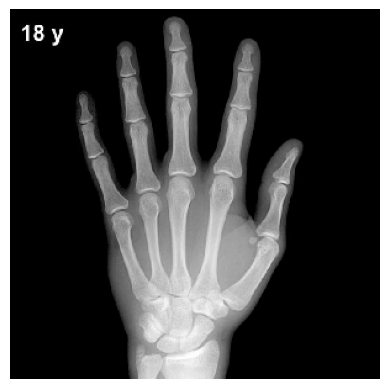

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
توقع النموذج: مكسورة (1.00)


In [ ]:
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input

# رفع الصورة
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# عرض الصورة
img = image.load_img(img_path, target_size=(300, 300))  # حجم مطابق للموديل
plt.imshow(img)
plt.axis('off')
plt.show()

# تحويل الصورة لمصفوفة
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# تحميل النموذج المدرب
model = load_model("fracture_model_epoch_05.h5")  # استخدم أحدث نسخة محفوظة

# التنبؤ
prediction = model.predict(img_array)[0][0]

# عرض النتيجة
if prediction >= 0.5:
    print(f"توقع النموذج: مكسورة ({prediction:.2f})")
else:
    print(f"توقع النموذج: غير مكسورة ({prediction:.2f})")


In [35]:
from tensorflow import keras

# تحميل الموديل
model = keras.models.load_model("fracture_model_final.keras")
print("✅ تم تحميل الموديل بنجاح")

# ضع أسماء الفئات حسب ما دربت عليه
class_names = ["Fractured", "Non-Fractured"]  # عدّل حسب فئاتك


ValueError: File not found: filepath=fracture_model_final.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
from PIL import Image
import numpy as np

def preprocess_image(image: Image.Image, target_size=(224,224)):
    """
    image: كائن PIL.Image
    target_size: الحجم المطلوب للموديل
    return: numpy array جاهزة للتنبؤ
    """
    # تحويل إلى RGB
    image = image.convert("RGB")

    # تغيير الحجم
    image = image.resize(target_size)

    # تحويل إلى array و normalize
    arr = np.array(image).astype("float32") / 255.0

    # إضافة batch dimension
    arr = np.expand_dims(arr, 0)  # تصبح shape (1, 224, 224, 3)

    return arr


In [ ]:
def predict_image(image: Image.Image):
    """
    image: كائن PIL.Image
    return: dict يحتوي على اسم الفئة ودرجة الثقة
    """
    # 1. preprocessing
    x = preprocess_image(image, target_size=(224,224))

    # 2. تمرير للموديل
    preds = model.predict(x)  # الشكل: (1, num_classes)

    # 3. أعلى فئة
    top_idx = int(np.argmax(preds[0]))
    prob = float(np.max(preds[0]))

    # 4. إعادة النتيجة
    return {
        "class": class_names[top_idx],
        "probability": prob
    }


In [ ]:
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import JSONResponse
from fastapi.middleware.cors import CORSMiddleware
from PIL import Image
import io
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input


In [ ]:
app = FastAPI()
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"],  # في الإنتاج عدّل المجال المسموح
    allow_methods=["*"],
    allow_headers=["*"],
)


In [ ]:
model = load_model("ls/content/sample_data/fracture_model_final.keras")
class_names = ["غير مكسورة", "مكسورة"]  # عدّل حسب فئاتك


ValueError: File not found: filepath=ls/content/sample_data/fracture_model_final.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def preprocess_image(img: Image.Image, target_size=(300,300)):
    img = img.convert("RGB")
    img = img.resize(target_size)
    x = np.array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x


In [ ]:
@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    # تحقق من نوع الملف
    if not file.content_type.startswith("image/"):
        raise HTTPException(status_code=400, detail="هذا الملف ليس صورة")
    try:
        contents = await file.read()
        img = Image.open(io.BytesIO(contents))
        x = preprocess_image(img, target_size=(300,300))
        pred = model.predict(x)[0][0]

        # تحويل النتيجة إلى فئة ودرجة الثقة
        if pred >= 0.5:
            result_class = class_names[1]
        else:
            result_class = class_names[0]

        return JSONResponse({
            "class": result_class,
            "probability": float(pred)
        })

    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))


In [ ]:
import nest_asyncio
import uvicorn

nest_asyncio.apply()
uvicorn.run(app, host="0.0.0.0", port=8000)


NameError: name 'app' is not defined